# Project: Identify Customer Segments

In this project, we apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we use has been provided by Udacity partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will:

1. Use this information to cluster the general population into groups with similar demographic properties. 
2. See how the people in the customers dataset fit into those created clusters. 

The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we load in the demographics data for the general population into a pandas DataFrame as well as the Feature Summary csv. 

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
# Visual assessment of the data
azdias.sample(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
636027,-1,3,1,4.0,4,3,4,2,2,2,...,3.0,3.0,1.0,0.0,1.0,3.0,4.0,3.0,5.0,1.0
227204,-1,3,2,5.0,3,3,4,4,2,3,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,4.0,5.0,5.0
124051,-1,3,2,6.0,1,5,3,5,4,5,...,3.0,3.0,1.0,0.0,1.0,2.0,3.0,2.0,4.0,1.0
820899,3,2,2,3.0,3,1,5,1,2,5,...,2.0,3.0,2.0,0.0,1.0,3.0,3.0,2.0,4.0,3.0
783265,-1,2,1,3.0,4,3,3,5,3,2,...,2.0,2.0,0.0,0.0,1.0,2.0,3.0,2.0,3.0,3.0
520684,-1,4,2,1.0,2,3,4,3,1,3,...,1.0,2.0,3.0,2.0,4.0,3.0,1.0,3.0,7.0,4.0
693482,1,4,1,4.0,5,1,5,1,2,2,...,3.0,3.0,2.0,0.0,1.0,4.0,4.0,3.0,7.0,2.0
399345,-1,3,2,2.0,4,2,4,4,2,1,...,3.0,2.0,1.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0
83190,-1,2,1,5.0,3,4,2,4,5,1,...,2.0,3.0,2.0,0.0,1.0,3.0,3.0,4.0,9.0,4.0
744363,-1,4,2,1.0,2,1,5,2,1,5,...,1.0,4.0,3.0,1.0,3.0,3.0,2.0,4.0,6.0,5.0


In [5]:
# Visual assessement of the feature info dataset
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we will assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. First we'll convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [6]:
# Create a copy of the original dataset and work on the copy
azdias_clean = azdias.copy()

In [7]:
# Identify missing or unknown data values and convert them to NaNs
# Every 0 or -1 value has to be replaced with NaN
azdias_clean = azdias_clean.replace([-1,0], np.nan)

In [8]:
# Next we need to replace the value 9 with NaN only for certain columns that contain 9 in the feat_info dataset:
cols_with_9 = []
row_name = ''

# Get a list of features that contain the number 9 in 'missing_or_unknown' column
for idx, row in enumerate(feat_info.missing_or_unknown):
        if str(9) in row:
            row_name = feat_info.attribute[idx]
            cols_with_9.append(row_name)
            
cols_with_9

['ALTERSKATEGORIE_GROB',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP',
 'ARBEIT',
 'RELAT_AB']

In [9]:
# Replace 9 with NaN for the above columns
azdias_clean[cols_with_9] = azdias_clean[cols_with_9].replace(9, np.nan)

# Check if it worked - After shouldn't contain value 9
# Before
print(azdias.ALTERSKATEGORIE_GROB.value_counts())

# After
print(azdias_clean.ALTERSKATEGORIE_GROB.value_counts())

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64
3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We will use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns the identify and document these columns. For this project we will just remove them from the dataframe. 

In [10]:
azdias_clean.isnull().sum() 

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE         715996
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
# Investigate patterns in the amount of missing data in each column.
col1 = azdias_clean.isnull().sum()  

# Create a DatFrame of null values
df_nulls = pd.DataFrame(data= col1, columns = ['number_of_nulls'])
df_nulls['percentage_of_nulls'] = azdias_clean.isnull().sum() / len(azdias_clean) * 100
df_nulls.head(50)

,number_of_nulls,percentage_of_nulls
AGER_TYP,685843,76.955435
ALTERSKATEGORIE_GROB,2881,0.323264
ANREDE_KZ,0,0.000000
CJT_GESAMTTYP,4854,0.544646
FINANZ_MINIMALIST,0,0.000000
FINANZ_SPARER,0,0.000000
FINANZ_VORSORGER,0,0.000000
FINANZ_ANLEGER,0,0.000000
FINANZ_UNAUFFAELLIGER,0,0.000000
FINANZ_HAUSBAUER,0,0.000000


Text(0.5,1,'Missing value distribution for each column')

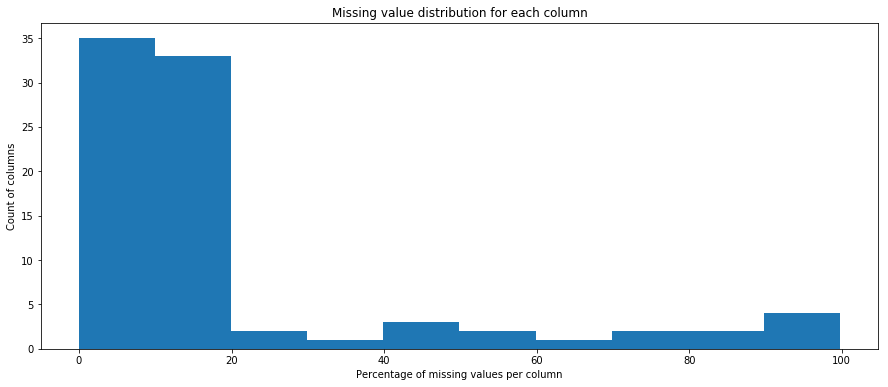

In [12]:
# Visualize the proportion of how much missing data there is in our columns
plt.figure(figsize=(15,6))
plt.hist(azdias_clean.isnull().sum() / len(azdias_clean) * 100);
plt.xlabel('Percentage of missing values per column')
plt.ylabel('Count of columns')
plt.title('Missing value distribution for each column')


In [13]:
# Get column names of columns that have *over* 20% of null values
high_null_count_cols = df_nulls.query('percentage_of_nulls > 20')
high_null_count_cols.index.values

array(['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SHOPPER_TYP',
       'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP',
       'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG3', 'PLZ8_ANTG4'], dtype=object)

In [14]:
# Remove these columns from our dataset - they have too many null values
remove_cols = high_null_count_cols.index.values
azdias_clean.drop(remove_cols, axis = 1, inplace=True)

# Check the new structure of our cleaned dataset
azdias_clean.shape

(891221, 68)

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Most columns have less than 20% of values that are missing. This was the threshold we chose to keep or remove columns from our dataset. All columns with over 20% of missing values were removed.

- Here is a sample of the columns we removed from the dataset: 

 'AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP'. 
 
- The dataset contains columns that can be grouped. For example there are columns related to fiancial data that start with FINANZ. There are also personnality columns that begin with SEMIO. These columns usually have the same amount of missing values meaning they were probably gathered in the same research exercise.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. We'll divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we'll see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We'll select at least five of these columns and compare the distribution of values.

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, for this project we will continue our analysis using just the subset of the data with few or no missing values.**

Text(0.5,1,'Missing value distribution for each row')

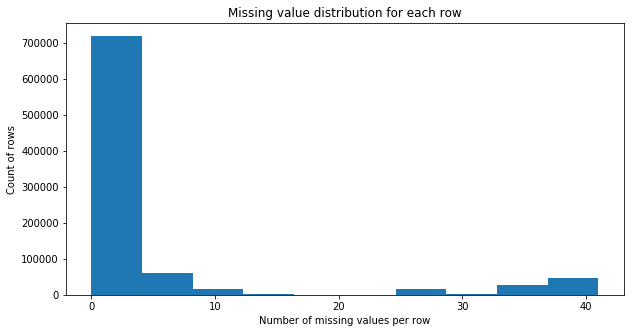

In [15]:
# How much data is missing in each row of the dataset?
plt.figure(figsize=(10,5))
plt.hist(68 - azdias_clean.count(axis=1), bins=10);
plt.xlabel('Number of missing values per row')
plt.ylabel('Count of rows')
plt.title('Missing value distribution for each row')

In [16]:
# create 2 DataFrames where number of NaN values for each row is lower than 5, and greater or equal than 5
low_nan_rows = azdias_clean[azdias_clean.isnull().sum(axis=1) < 5]
high_nan_rows = azdias_clean[azdias_clean.isnull().sum(axis=1) >= 5]

# Check how many total rows there are for both new datasets
len(low_nan_rows), len(high_nan_rows)

(719376, 171845)

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Find 5 columns with 0 missing values
no_nan_values = (high_nan_rows.isnull().sum()) == 0
no_nan_values.index

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',


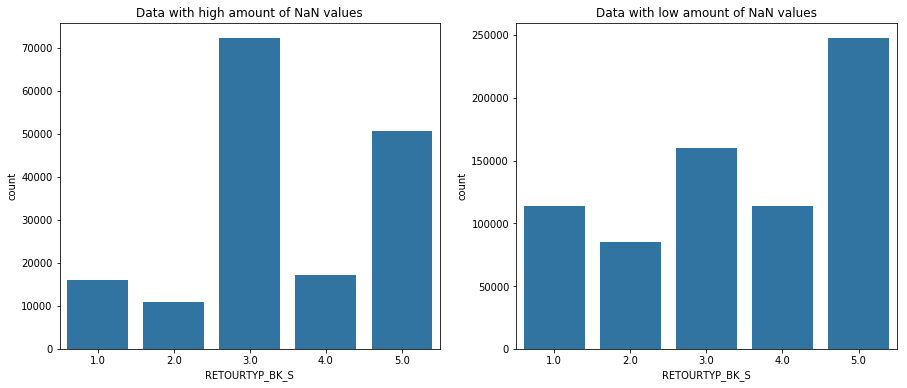

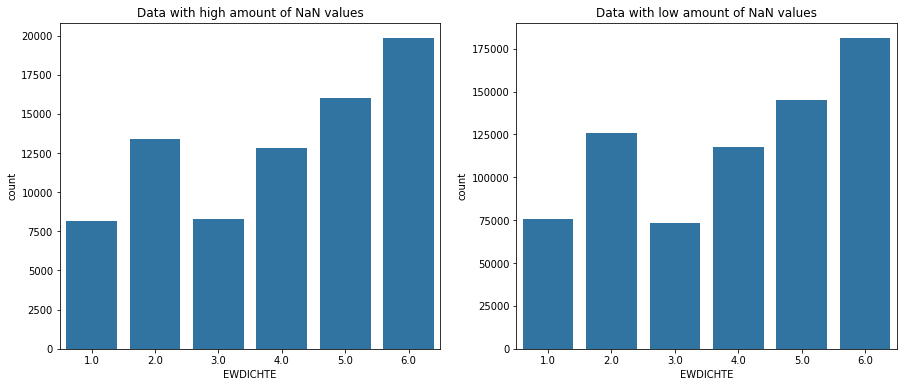

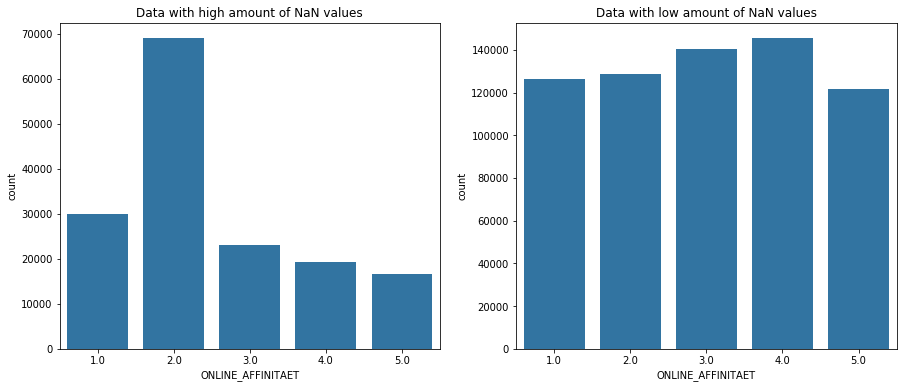

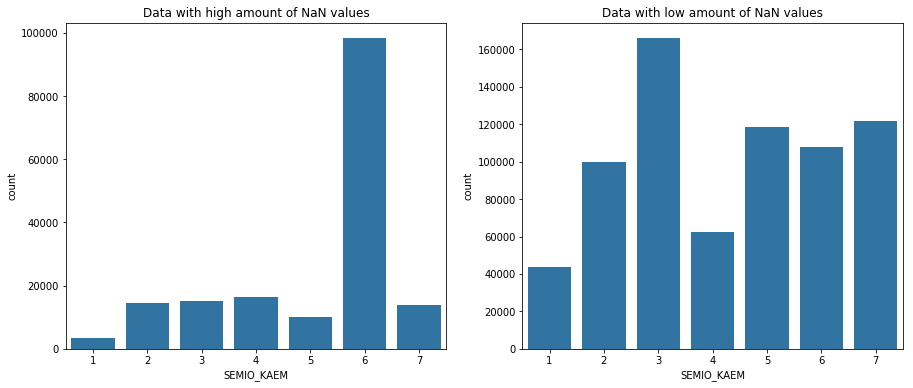

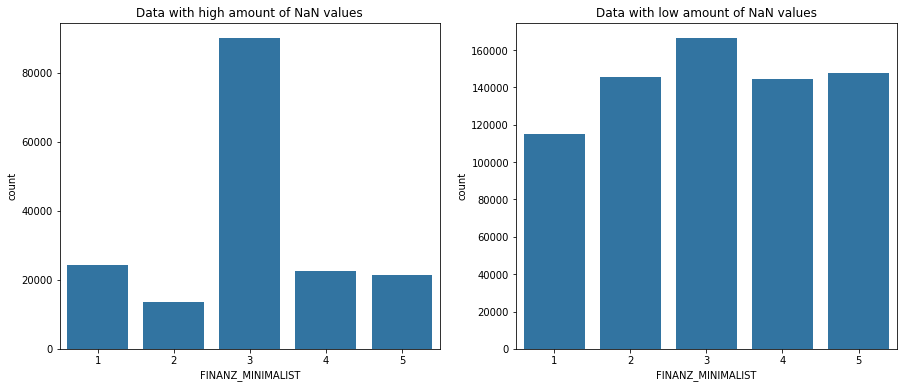

In [18]:
# Get all cols with no missing values
cols = list(no_nan_values.index)

# Function that compares the distribution between our DataFrames of high and low amount of NaN values
def compare_distrib(col_name):

    base_color = sns.color_palette()[0]

    fig = plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    ax1 = sns.countplot(x= col_name, data = high_nan_rows, color = base_color)
    plt.title('Data with high amount of NaN values')

    plt.subplot(1, 2, 2)
    sns.countplot(x= col_name, data = low_nan_rows, color = base_color)
    plt.title('Data with low amount of NaN values')

# Compare 5 random distributions within the cols list
for col in random.sample(cols, 5):
    compare_distrib(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on my observations, our dataset with lots of missing values has, for about 1/3rd of our columns, qualitatively different data than our dataset with few or no missing values. In other words, there is almost no difference in the distribution of values for 2/3rds of our columns, and a big difference for the remaining third. For example, the distributions are very different for the following columns: SEMIO_DOM, SEMIO_PFLICH, SEMIO_TRADV. 

In normal cases, we would want to keep the data with different distributions because in removing them we lose some of the variability of our dataset. 

As mentioned before, for the purposes of this project, **we will continue our analysis using just the subset of the data with few or no missing values.**

In [19]:
# use azdias_new for the remainder of our analysis
azdias_new = low_nan_rows.copy()
azdias_new.shape

(719376, 68)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. We can check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

Text(0.5,1,'Count of each data type')

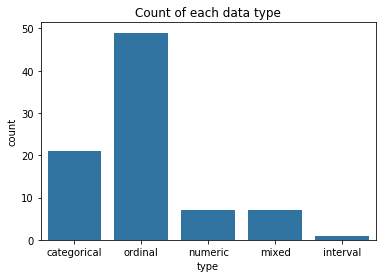

In [20]:
# How many features are there of each data type? Let's visualize this first
base_color = sns.color_palette()[0]
sns.countplot(x='type', data= feat_info, color = base_color)
plt.title('Count of each data type')

In [21]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [22]:
# Get a list of all categorical columns 
category_data = feat_info.query('type == "categorical" ' ) 
cat_names = list(category_data.attribute.values)

cat_names

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [23]:
# Print all possible values for our categorical features to see which ones to keep
categorical_features = []
for attr in cat_names:
    if attr in (azdias_clean.columns):
        print('{}:        '.format(attr), azdias_clean[attr].unique())
        categorical_features.append(attr)

ANREDE_KZ:         [1 2]
CJT_GESAMTTYP:         [  2.   5.   3.   4.   1.   6.  nan]
FINANZTYP:         [4 1 6 5 2 3]
GFK_URLAUBERTYP:         [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN:         [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB:         [  2.   3.   1.  nan   5.   4.]
LP_STATUS_FEIN:         [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB:         [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ:         [ nan   1.   3.   2.]
VERS_TYP:         [ nan   2.   1.]
ZABEOTYP:         [3 5 4 1 6 2]
GEBAEUDETYP:         [ nan   8.   1.   3.   2.   6.   4.   5.]
OST_WEST_KZ:         [nan 'W' 'O']
CAMEO_DEUG_2015:         [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
CAMEO_DEU_2015:         [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B'

In [24]:
# For simplicity, keep only categories that are binary
cats_to_keep = ['ANREDE_KZ', 'VERS_TYP', 'OST_WEST_KZ']

# Create a variable with categories we want to drop
cats_to_drop = [e for e in categorical_features if e not in cats_to_keep]
cats_to_drop

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# Remove categories that are not binary from our dataframe
azdias_new.drop(cats_to_drop, axis=1, inplace=True)
azdias_new.shape

(719376, 56)

In [26]:
# Re-encode 'OST_WEST_KZ' category
azdias_new.OST_WEST_KZ.replace(('W', 'O'), (1, 0), inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

For the sake of simplicity, I decided to only keep categorical features that were binary. The categories that were kept were the following: 'ANREDE_KZ', 'VERS_TYP', 'OST_WEST_KZ'. 

For OST_WEST_KZ, I had to re-encode the data to numerical values so that our algorithm can interpret it. 
All other categorical features were removed. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.


In [27]:
# Check all values of PRAEGENDE_JUGENDJAHRE
azdias_new.PRAEGENDE_JUGENDJAHRE.unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,   5.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Values associated with mainstream movement
mainstream = [1, 3, 5, 8, 10, 12, 14]

# Create new column with 0 for 'mainstream' and 1 for 'avantgarde'
azdias_new['movement'] = np.where(azdias_new['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 1) 

In [29]:
# check value counts
azdias_new['movement'].value_counts()

0    548154
1    171222
Name: movement, dtype: int64

In [30]:
'''
Numbers associated with decade: 

40s = 1, 2
50s = 3, 4
60s = 5, 6, 7
70s = 8, 9 
80s = 10, 11, 12, 13 
90s = 14, 15
'''

# map old values to new decade values
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

azdias_new['decade'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].replace(decade)


In [31]:
azdias_new['decade'].value_counts()

6.0    207596
4.0    162620
5.0    140956
3.0    106979
2.0     69068
1.0     24254
Name: decade, dtype: int64

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
'''
11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement
XX: unknown'''
azdias_new.CAMEO_INTL_2015.value_counts()

51    120572
41     83636
24     83390
14     57683
43     51707
54     41368
25     36436
22     29939
13     24104
45     24067
23     21755
55     21232
52     18597
34     16722
31     16139
15     15875
44     13437
12     12105
32      9498
35      9401
33      8896
XX       277
Name: CAMEO_INTL_2015, dtype: int64

In [33]:
# map old values to wealth and life_stage
wealth = {11:1, 12:1, 13:1, 14:1, 15:1, 
          21:2, 22:2, 23:2, 24:2, 25:2, 
          31:3, 32:3, 33:3, 34:3, 35:3, 
          41:4, 42:4, 43:4, 44:4, 45:4,
          51:5, 52:5, 53:5, 54:5, 55:5}

life_stage = {11:1, 12:2, 13:3, 14:4, 15:5, 
              21:1, 22:2, 23:3, 24:4, 25:5, 
              31:1, 32:2, 33:3, 34:4, 35:5, 
              41:1, 42:2, 43:3, 44:4, 45:5,
              51:1, 52:2, 53:3, 54:4, 55:5}
# Convert value 'XX' to NaN 
azdias_new = azdias_new.replace('XX', np.nan)

In [34]:
# Create 2 new columns with our maped values
azdias_new['wealth'] = azdias_new['CAMEO_INTL_2015'].astype(float).replace(wealth)
azdias_new['life_stage'] = azdias_new['CAMEO_INTL_2015'].astype(float).replace(life_stage)

In [35]:
azdias_new['wealth'].value_counts()

5.0    201769
4.0    172847
2.0    171520
1.0    109767
3.0     60656
Name: wealth, dtype: int64

In [36]:
azdias_new['life_stage'].value_counts()

1.0    220347
4.0    212600
5.0    107011
3.0    106462
2.0     70139
Name: life_stage, dtype: int64

In [37]:
# drop our old columns
old_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
azdias_new.drop(old_cols, axis=1, inplace=True)

# We should end up with 2 more columns than before: 58
azdias_new.shape

(719376, 58)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For mixed-types features I split "PRAEGENDE_JUGENDJAHRE" column into two new ones: 'movement' and 'decade'. 

Same for "CAMEO_INTL_2015" which was split in two new columns: 'life_stage' and 'wealth'. 

After the split, both "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were droped from our dataframe. 

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data later on, we will just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df_to_clean):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    ### 1. Convert missing values ###
    
    # convert missing values [-1, 0] to NaNs for all columns
    df_to_clean = df_to_clean.replace([-1,0], np.nan)
    
    # convert missing value '9' to NaNs just for certain columns
    cols_with_9 = ['ALTERSKATEGORIE_GROB', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 
                   'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 
                   'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                   'SEMIO_TRADV', 'ZABEOTYP', 'ARBEIT', 'RELAT_AB']
    
    df_to_clean[cols_with_9] = df_to_clean[cols_with_9].replace(9, np.nan)
    
    
    ### 2. Remove columns and rows ###
    
    # remove columns that have over 20% NaN among all values
    remove_cols = ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SHOPPER_TYP',
                   'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 
                   'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 
                   'KBA05_BAUMAX', 'PLZ8_ANTG3', 'PLZ8_ANTG4']
    # Remove these columns from our dataset
    df_to_clean.drop(remove_cols, axis = 1, inplace=True)
    
    # Remove rows where number of NaN values for each row is lower than 5
    df_to_clean = df_to_clean[df_to_clean.isnull().sum(axis=1) < 5]
    
    
    ### 3. Re-encode and enginner column values ### 

    # List of categories to drop
    cats_to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                    'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                    'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    # Remove categories that are not binary from our dataframe
    df_to_clean.drop(cats_to_drop, axis=1, inplace=True)
    # Re-encode 'OST_WEST_KZ' category
    df_to_clean.OST_WEST_KZ.replace(('W', 'O'), (1, 0), inplace=True)

    # Values associated with mainstream movement
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    # Create new column with 0 for 'mainstream' and 1 for 'avantgarde'
    df_to_clean['movement'] = np.where(df_to_clean['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 1) 

    # map old values to new decade values
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    df_to_clean['decade'] = df_to_clean['PRAEGENDE_JUGENDJAHRE'].replace(decade)
    # map old values to wealth and life_stage
    wealth = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4,
              51:5, 52:5, 53:5, 54:5, 55:5}

    life_stage = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5,
                  51:1, 52:2, 53:3, 54:4, 55:5}
    
    # Convert value 'XX' to NaN 
    df_to_clean = df_to_clean.replace('XX', np.nan)

    # Create 2 new columns with our maped values
    df_to_clean['wealth'] = df_to_clean['CAMEO_INTL_2015'].astype(float).replace(wealth)
    df_to_clean['life_stage'] = df_to_clean['CAMEO_INTL_2015'].astype(float).replace(life_stage)

    # drop our old columns
    old_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df_to_clean.drop(old_cols, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_to_clean
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we need make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 

In [39]:
# Clean null values

# First round of getting rid of null values. 
azdias_new.fillna(method='ffill', axis=0)

# Second round of getting rid of null values with imputer
imputer = Imputer(missing_values='NaN', strategy='most_frequent')
df_azdias = pd.DataFrame(imputer.fit_transform(azdias_new))
df_azdias.columns = azdias_new.columns
df_azdias.index = azdias_new.index

In [40]:
# Check if there are null values remaining
df_azdias.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
VERS_TYP                 0
ANZ_PERSONEN             0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_GBZ                0
B

In [41]:
# Check if we will have our desired shape
df_azdias.shape

(719376, 58)

In [42]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_df =  scaler.fit_transform(df_azdias)
scaled_df.shape

(719376, 58)

### Discussion 2.1: Apply Feature Scaling

In order to clean the missing values we did so in two steps: 1. Forward filling 2. Impute with most frequent. 
1. First round of getting rid of null values consisted of forward filling. This means that each null value is replaced by the value right before it. However, this technique doesn't fill all the null values in the dataset. 

Reasoning: Since some of the columns contain as much as 20% of null values, I didn't want to fill the null values with just 1 unique number. Forward filling might bias the data and give it a bit of randomness but we are not over representing the data with one chosen value. 

2. After forward filling, there still are some null values in the dataset. We use a 'most frequent' imputer to deal with the remaining null values. 

Once that was done we applied a standard scaler and fit_transformed the dataset. 

### Step 2.2: Perform Dimensionality Reduction

We are now ready to apply dimensionality reduction techniques on our scaled dataset.

- We will ue sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- We will then check out the ratio of variance explained by each principal component as well as the cumulative variance explained. 

In [43]:
# Apply PCA to the data with 25 components
pca = PCA(n_components=25)
pca.fit_transform(scaled_df)

array([[ 3.76832693, -1.80288113, -3.12590032, ..., -0.36543019,
        -0.51747838, -0.44078924],
       [-0.18028224,  0.69851045, -3.06722011, ..., -1.02397373,
        -0.31782557, -0.21122224],
       [-0.17480574, -0.00891077,  3.28943061, ..., -0.32926164,
         0.3150302 ,  0.73149334],
       ..., 
       [ 3.18891779,  2.40040697,  1.3754668 , ..., -1.03696466,
         0.06768043, -0.08876293],
       [ 6.14548184, -1.73028709,  2.36963999, ...,  0.16303323,
        -0.23064851,  0.01935581],
       [-0.95888261,  0.29997724,  2.98320236, ..., -0.12785857,
        -0.53431814, -0.60892068]])

In [44]:
# Variance explained by each principal component
pca.explained_variance_ratio_


array([ 0.16986668,  0.14331627,  0.10449819,  0.05661602,  0.04654677,
        0.0358773 ,  0.0304516 ,  0.02665376,  0.02460171,  0.02264743,
        0.02169643,  0.02036561,  0.01755365,  0.01639265,  0.01493044,
        0.01446866,  0.0135496 ,  0.01278981,  0.01234942,  0.01156117,
        0.01122083,  0.01056486,  0.00991057,  0.00877323,  0.00848974])

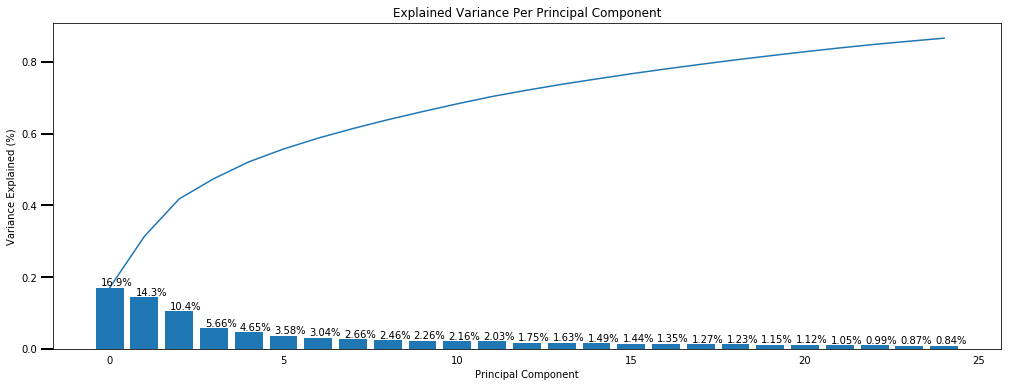

In [45]:
# Function that plots the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(17, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [46]:
# Re-apply PCA to the data and keep principal components with an explained variance ratio above 1%
pca = PCA(n_components=21)
pca_X = pca.fit_transform(scaled_df)
pca_X

array([[ 3.76832787, -1.80287767, -3.12590764, ...,  0.38882606,
        -0.82871349, -0.69193317],
       [-0.18028429,  0.69850513, -3.06721139, ...,  1.09465843,
        -0.08009732, -0.21496404],
       [-0.17480566, -0.00891221,  3.28943607, ..., -0.45902485,
        -0.25748788,  1.3090009 ],
       ..., 
       [ 3.18891909,  2.4004079 ,  1.3754527 , ..., -1.15008713,
         0.69179438,  0.60803181],
       [ 6.14548157, -1.73028705,  2.36962481, ..., -1.12390547,
         0.90143515,  0.42069246],
       [-0.95888306,  0.29997905,  2.98320463, ...,  1.34340557,
        -0.81457302, -0.42834149]])

In [47]:
# Total variance explained with our 21 principal components
pca.explained_variance_ratio_[:21].sum()

0.82788836225257489

### Discussion 2.2: Perform Dimensionality Reduction

The explaned variance ratio for our first three components is: 16.9%, 14.3% and 10.4%. After that, the ratio drops to 5% and below. 

I decided to keep only the components where their explained variance ratio was above 1%. 

In doing this, our total explained variance ratio totaled 82.79%.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we will map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We can use the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You will investigate and interpret feature associations from the first three principal components in this substep. 

In [48]:
# index components for our dataframe
components = [f'Component {i}' for i in range(1,len(pca.components_)+1)]

# PCA components sorted
df_components = pd.DataFrame(np.round(pca.components_, 4), columns = df_azdias.keys())
df_components.index = components

# sort by the first dimension
df_components.sort_values(by=df_components.index[0], axis=1, ascending=False, inplace=True)

# show the components of the first three dimensions
df_components.iloc[:3].transpose()

,Component 1,Component 2,Component 3
FINANZ_SPARER,0.2137,-0.1763,-0.1090
PLZ8_BAUMAX,0.1882,0.1537,0.0576
SEMIO_REL,0.1841,-0.2159,0.0700
HH_EINKOMMEN_SCORE,0.1833,0.1165,-0.0085
SEMIO_PFLICHT,0.1817,-0.1799,-0.0825
wealth,0.1796,0.1361,0.0373
ORTSGR_KLS9,0.1770,0.1648,0.0577
decade,0.1745,-0.1954,-0.1156
EWDICHTE,0.1730,0.1640,0.0571
SEMIO_TRADV,0.1626,-0.1874,-0.0923


In [49]:
# Create function to get list of sorted weights for each feature of a component we choose

def get_sorted_weights_list(df, component):
    
    # Get sorted PCA components
    df_components.sort_values(by=df_components.index[component], axis=1, ascending=False, inplace=True)
    
    # Get the top 6 weighted features
    sorted_weights = df_components.iloc[component]
    
    return sorted_weights

# Get sorted weights for the first dimension
get_sorted_weights_list(df_azdias, 0)    

FINANZ_SPARER            0.2137
PLZ8_BAUMAX              0.1882
SEMIO_REL                0.1841
HH_EINKOMMEN_SCORE       0.1833
SEMIO_PFLICHT            0.1817
wealth                   0.1796
ORTSGR_KLS9              0.1770
decade                   0.1745
EWDICHTE                 0.1730
SEMIO_TRADV              0.1626
PLZ8_ANTG2               0.1473
SEMIO_RAT                0.1472
FINANZ_UNAUFFAELLIGER    0.1427
SEMIO_KULT               0.1334
ARBEIT                   0.1280
SEMIO_FAM                0.1272
SEMIO_MAT                0.1263
FINANZ_HAUSBAUER         0.1244
FINANZ_ANLEGER           0.1222
RELAT_AB                 0.1194
ANZ_HAUSHALTE_AKTIV      0.1167
SEMIO_SOZ                0.0709
REGIOTYP                 0.0536
HEALTH_TYP               0.0501
KKK                      0.0344
PLZ8_HHZ                 0.0332
VERS_TYP                 0.0185
W_KEIT_KIND_HH           0.0162
SEMIO_KAEM               0.0088
SEMIO_DOM                0.0084
ONLINE_AFFINITAET       -0.0075
ANREDE_K

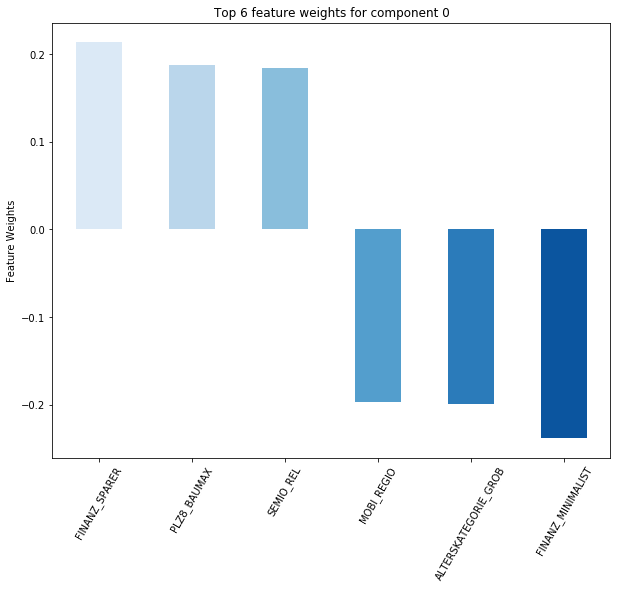

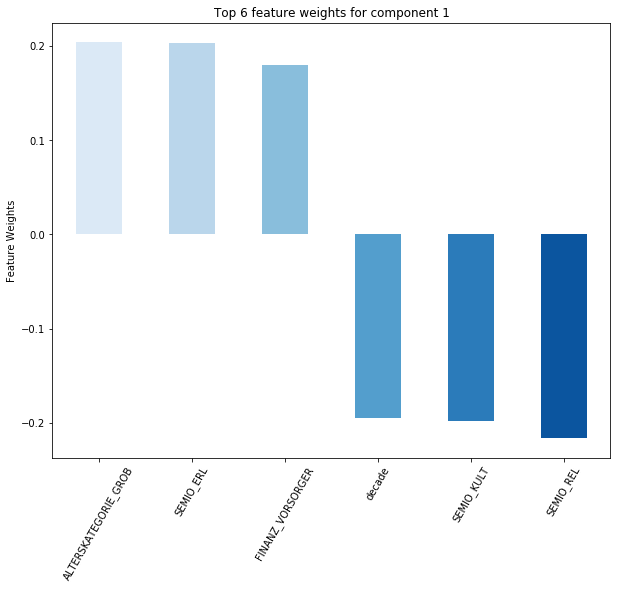

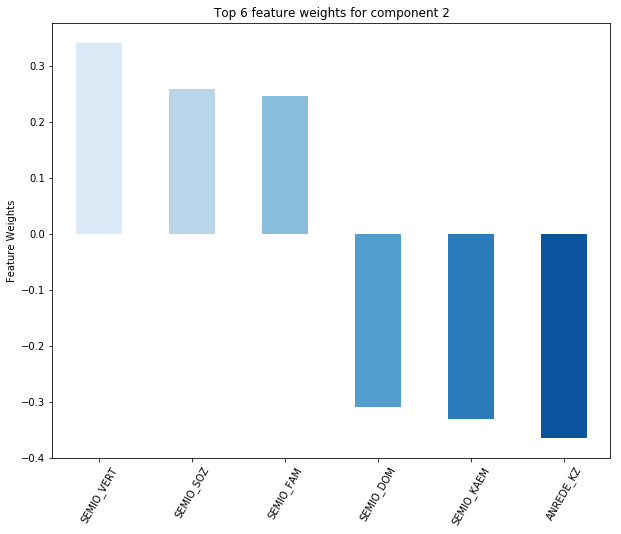

In [50]:
# Visualize the top 6 features for our first 3 components
def plot_top_6_features(component):
    
    # Get sorted PCA components 
    df_components.sort_values(by=df_components.index[component], axis=1, ascending=False, inplace=True)
    
    # Get the top 6 weighted features
    top_features = df_components.iloc[component][:3].append(df_components.iloc[component][-3:])
    
    fig, ax = plt.subplots(figsize = (10,8));

    # Plot the feature weights as a function of the components
    base_color = sns.color_palette("Blues")
    top_features.plot(kind='bar', color = base_color);
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(top_features.index, rotation=60);
    ax.set_title(f'Top 6 feature weights for component {component}');
    
    return top_features

# Get top features for the first 3 dimensions 
for dim in range(3):
    plot_top_6_features(dim)

### Discussion 2.3: Interpret Principal Components

The features with the most importance for our **first** component are:
- FINANZ_SPARER: Money-saver: from very low to very high
- PLZ8_BAUMAX: Most common building type within the PLZ8 region
- SEMIO_REL: Religious affinity
- FINANZ_MINIMALIST: Low financial interest: from very low to very high
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- MOBI_REGIO: Movement patterns
The first three features on the list seem to be positively correlated to one another because their weights are positive. Likewise for the bottom three features which have negative weights. 

The features with the most importance for our **second** component are:
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- SEMIO_REL: Religious affinity
- FINANZ_VORSORGER: Financial typology - be prepared
- SEMIO_ERL: Personality typology - event oriented
- decade: The decade dominating the movement of a person's youth 
- SEMIO_KULT: Personality typology - Cultural minded
The first three features on the list seem to be positively correlated to one another because their weights are positive. Likewise for the bottom three features which have negative weights. 

The features with the most importance for our **thrid** component are:
- SEMIO_VERT: Personality typology - dreamful
- SEMIO_SOZ: Personality typology - socially-minded
- SEMIO_FAM: Personality typology - family-minded
- ANDREDE_KZ: Info missing
- SEMIO_KAEM: Personality typology - combative attitude
- SEMIO_DOM: Personality typology - dominant-minded
The first three features on the list seem to be positively correlated to one another because their weights are positive. Likewise for the bottom three features which have negative weights. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

So far we've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


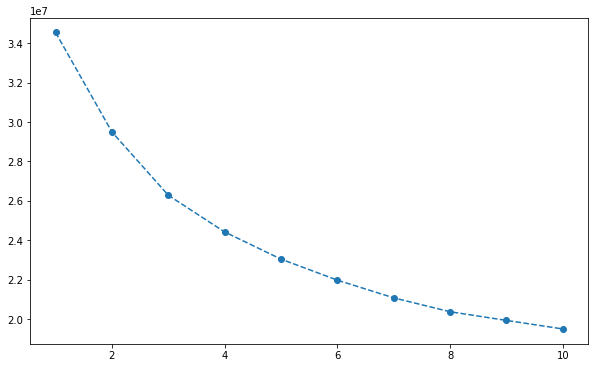

In [51]:
clusters = []
scores = []

# Loop through the number of clusters and run k-means on the data
for k in range(10):
    k+= 1
    kmeans = KMeans(k, n_jobs = -1).fit(pca_X)
    score = np.abs(kmeans.score(pca_X))
    scores.append(score)
    clusters.append(k)

# Graph the change in within-cluster distance across the number of clusters
fig = plt.figure(figsize=(10,6))
plt.plot(clusters, scores, linestyle='--', marker='o')  

In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(6, n_jobs = -1).fit(pca_X)
general_labels = kmeans.predict(pca_X)

### Discussion 3.1: Apply Clustering to General Population

The number of centroids chosen is 6. After 6, our score continues to drop but in a less significant manner. We could have also chosen 8, because the scores decline notably less after as well. However in practice, my experience has shown that working with 6 groups, or personas is ideal. Less and we may miss our on characteristics of our customers. With more than 6 our groups tend to be smaller and it becomes hard to understand the differences between the groups.  

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We're going to use the fits from the general population to clean, transform, and cluster the customer data (which is different that refitting the data). In the last step of the project, we will interpret how the general population fits apply to the customer data.

In [53]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0


In [54]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)


In [55]:
# Clean the customers dataset in the same way we cleaned the population dataset
# First round of getting rid of null values. 
customers.fillna(method='ffill', axis=0)

# Second round of getting rid of null values with imputer
customers_cleaned = pd.DataFrame(imputer.fit_transform(customers))
customers_cleaned.columns = customers.columns
customers_cleaned.index = customers.index

In [56]:
# Check the shape of our cleaned customers DataFrame to see if the columns match our population dataset
customers_cleaned.shape

(128401, 58)

In [57]:
# Use the fitted scaler, pca, and kmeans to transform our customers DataFrame
customers_X = scaler.transform(customers_cleaned)
customers_pca = pca.transform(customers_X)
customers_kmeans = kmeans.transform(customers_pca)

# Get customer cluster predictions
customer_labels = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

We will consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We will proceed with the following steps:

- Compute and visualize the proportion of data points in each cluster for the general population and the customer data. 
- Find which cluster or clusters are overrepresented in the customer dataset compared to the general population. We will select at least one such cluster and infer what kind of people might be represented by that cluster. We will use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values.
- We will then perform a similar investigation for the underrepresented clusters and find what kinds of people are typified by these clusters?

In [58]:
# Create a dataframe with general population and customer cluster labels
columns = ['general_labels', 'customer_labels']
df = pd.DataFrame.from_dict({'general_labels':pd.Series(general_labels)+1, 'customer_labels':pd.Series(customer_labels)+1})

# Convert column to floats to match the type of 'customer_labels'
df.general_labels = df.general_labels.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719376 entries, 0 to 719375
Data columns (total 2 columns):
general_labels     719376 non-null float64
customer_labels    128401 non-null float64
dtypes: float64(2)
memory usage: 11.0 MB


Text(0.5,1,'Customer Cluster Count')

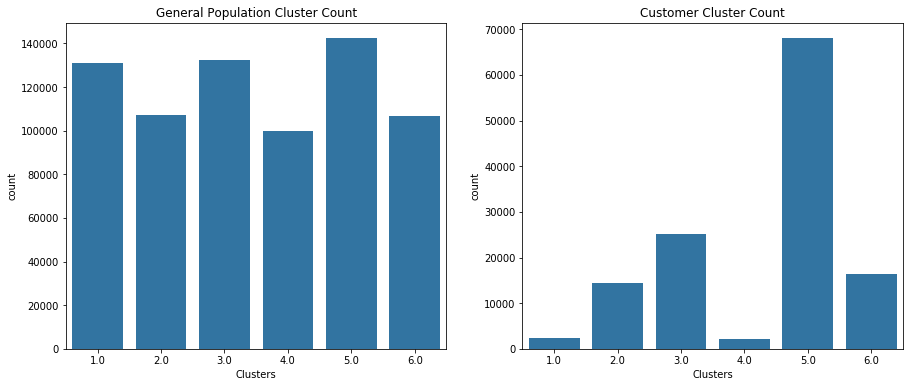

In [59]:
# Visualize the distribution of clusters
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(data = df, x='general_labels', color =  base_color)
plt.xlabel('Clusters')
plt.title('General Population Cluster Count')


plt.subplot(1, 2, 2)
sns.countplot(data = df, x='customer_labels', color = base_color)
plt.xlabel('Clusters')
plt.title('Customer Cluster Count')

In [60]:
# Get cluster ratios
customer_ratios = []
general_ratios = []
for n in range(6):
    customer_ratios.append(list(customer_labels).count(n) / len(customer_labels))
    general_ratios.append(list(general_labels).count(n) / len(general_labels))

In [61]:
# Create the Ratios DF
columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6']
index = ['Customer_ratios', 'General_ratios']
df2 = pd.DataFrame([customer_ratios, general_ratios], columns=columns, index=index)
df2

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
Customer_ratios,0.018209,0.112546,0.195544,0.016596,0.530011,0.127094
General_ratios,0.182044,0.148825,0.183811,0.138851,0.197948,0.148522


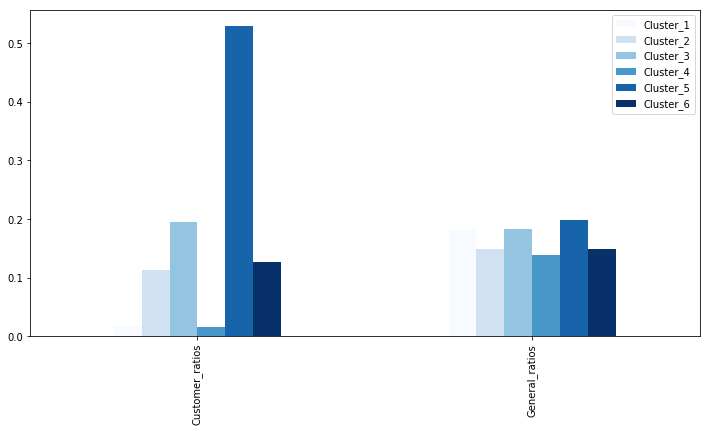

In [62]:
# plot the cluster ratios and compare
df2.plot(kind = 'bar', figsize=(12, 6), colormap = 'Blues')

In [63]:
# Choose a cluster and use inverse_transform to retrieve info about the cluster
def cluster_representation(k, kmeans_predictions):

    # inverse scale and inverse transform our PCA data for the chosen cluster
    cluster_data = scaler.inverse_transform(pca.inverse_transform(pca_X[kmeans_predictions==k]))

    # create a dataframe of our cluster and round the numbers 
    df_cluster = pd.DataFrame(cluster_data.round(), columns = customers_cleaned.columns)
    
    # Take the features that had the highest weights for the first principal component
    # These were the features that had the highest importance - let's visualize them with only the data of our cluster
    cols = ['FINANZ_SPARER', 'FINANZ_MINIMALIST', 'ALTERSKATEGORIE_GROB', 'PLZ8_BAUMAX', 'SEMIO_REL', 'MOBI_REGIO']
    
    # Plot distribution of most important features for our cluster
    fig, axes = plt.subplots(2, 3) # grid of 2x3 subplots
    fig.set_figheight(10)
    fig.set_figwidth(15)
    axes = axes.flatten() # reshape from 2x3 array into 6-element vector
    for i in range(6):
        plt.sca(axes[i]) # set the current Axes
        sns.countplot(x=cols[i], data = df_cluster, color = base_color)


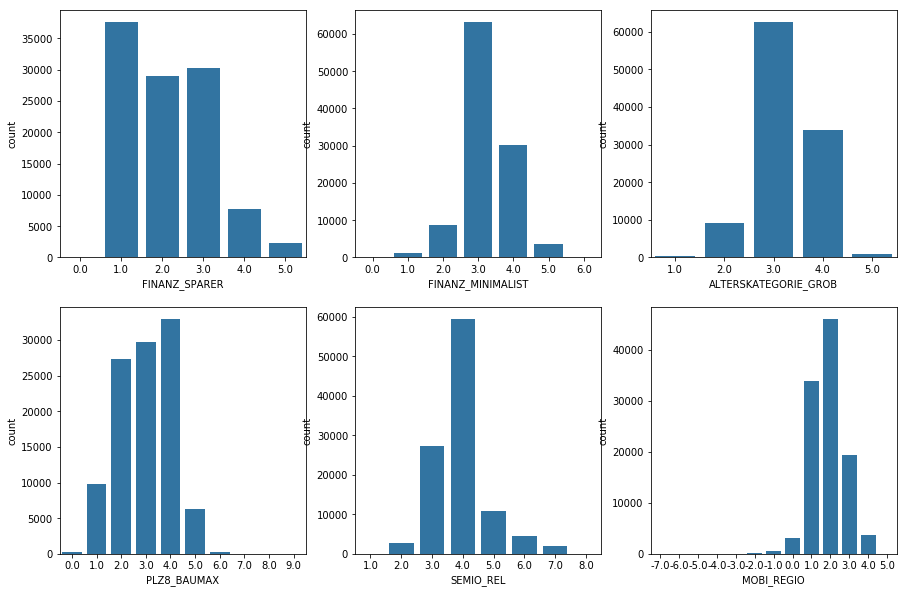

In [73]:
# Check demographics of people in cluster 5, which is most represented cluster in our customer dataset
cluster_representation(5, kmeans_predictions=general_labels)


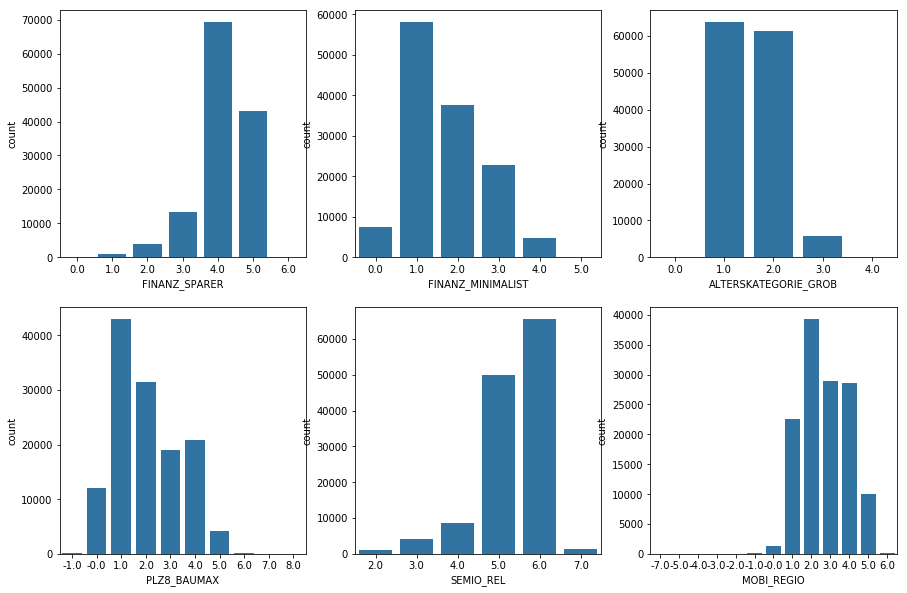

In [72]:
# Check demographics of people in cluster 1, which is most unrepresented cluster in our customer dataset
cluster_representation(0, kmeans_predictions=general_labels)


### Discussion 3.3: Compare Customer Data to Demographics Data

- Cluster #5 represents about 53% of the customer dataset. Clusters 1 and 4 are barely represented with ratios of 1.6% and 1.8% only. This means that we can use cluster #5's information to target similar profiles in the population. 

Let's analyse cluster #5 more closely:  
- FINANZ_SPARER: People in cluster #5 tend to be high money savers. In contrast, people in cluster #1 are the oposite. 
- FINANZ_MINIMALIST: The vast majority have average to low financial interest where as cluster #1 contains people with very high financial interest. 
- ALTERSKATEGORIE_GROB: The majority of cluster #5 is aged between 46 and 60. Another big age group is over 60 years old. 
- PLZ8_BAUMAX: The building type within the PLZ8 region is similar between the clusters. 
- SEMIO_REL: Cluster #5 contains people with average religious affinity. Underrepresented clusters like #1 have, in comparison, low to very low religious affinity. 
- MOBI_REGIO: This features measures one's movement pattern. Cluster 6 is associated with people that have mostly high to very high movement. 



## Assumptions and limitations

- A lot of the variables in the dataset are ordinal. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- We removed a lot of categorical features which could have contained important information. We made this decision to keep our model simple. 
- There are a few features of type 'mixed' which we left untouched. We could have split them into multiple features because each unique value contains more than 1 type of information. These mixed features were left untouched to keep the model simple. 
- The clustering algorithm used was kmeans. Other types of clustering algorithms could have been used and compared which each other. 

